In [3]:
#Load a specific lightcurve file for testing purposes
import json
import sys
import numpy as np
import emcee
import george
import matplotlib.pyplot as plt
sys.path.append('../classification')
import os
filenames = ['../gen_lightcurves/gp_smoothed/SN2005el_gpsmoothed.json','../gen_lightcurves/gp_smoothed/SDSS-II SN 18165_gpsmoothed.json',
            '../gen_lightcurves/gp_smoothed/SN2004dj_gpsmoothed.json']

file_data = {}

for filename in filenames:
    with open(filename, 'r') as f:
         temp_file_data = json.load(f)
    print(temp_file_data.keys())
    for key in temp_file_data:
        file_data[key] = temp_file_data[key]


dict_keys(['B_', 'B__CSP', 'B_kait3', 'H_PAIRITEL', 'H__CSP', 'I_kait3', 'J_PAIRITEL', 'J__CSP', 'Ks_PAIRITEL', 'R_kait3', 'U_', 'V_', 'V__CSP', 'V_kait3', 'Y__CSP', 'g__CSP', 'i__CSP', 'r__CSP', 'u__CSP'])
dict_keys(['gprime_SDSS_SDSS', 'rprime_SDSS_SDSS'])
dict_keys(['B_', 'I_', 'R_', 'U_', 'V_'])


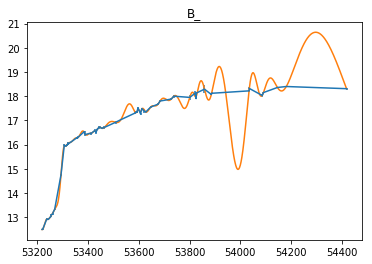

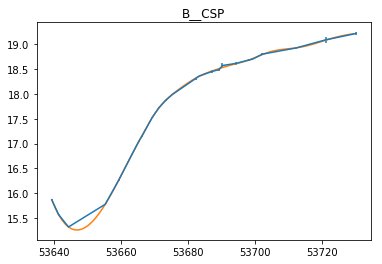

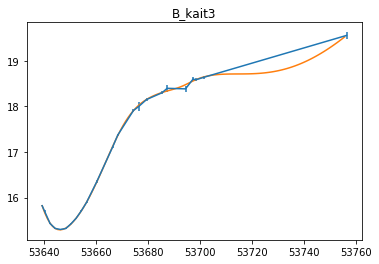

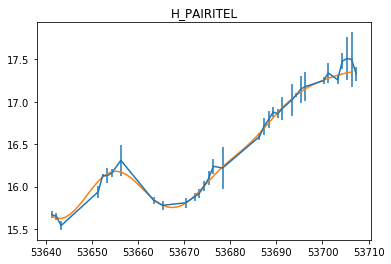

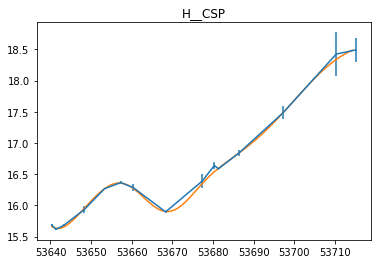

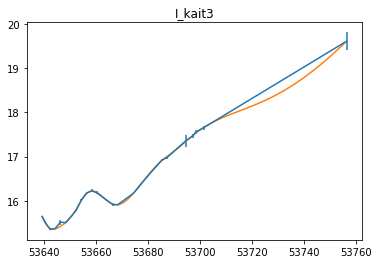

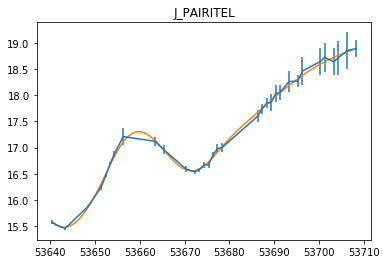

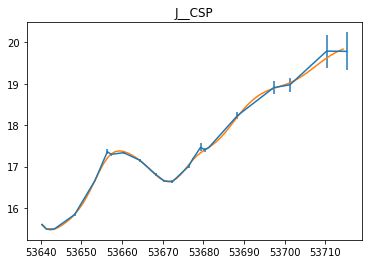

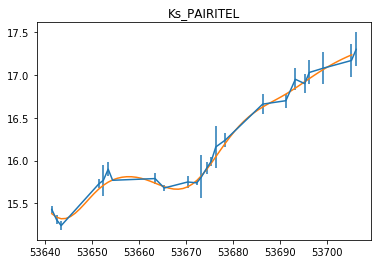

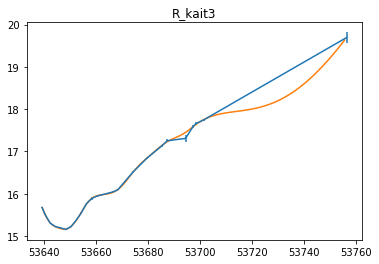

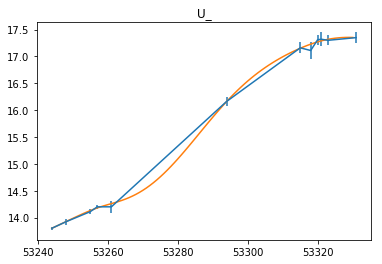

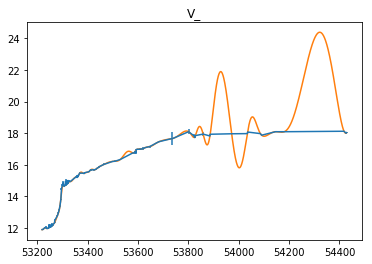

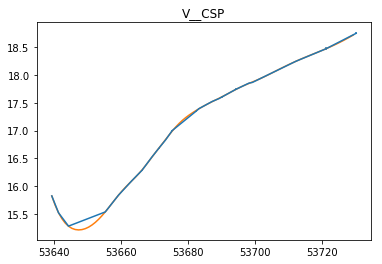

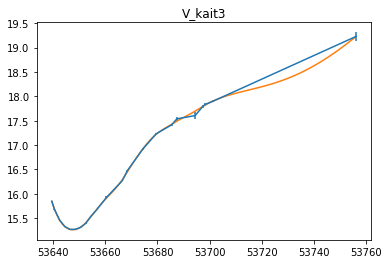

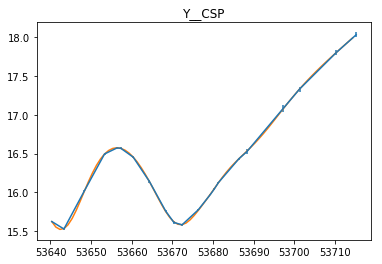

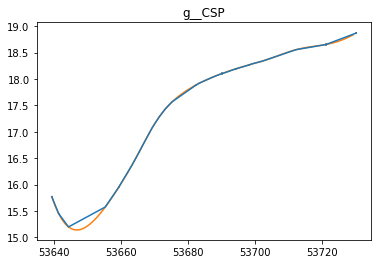

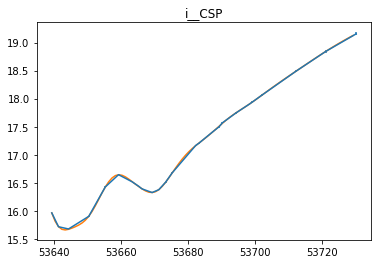

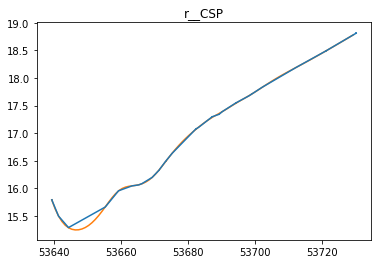

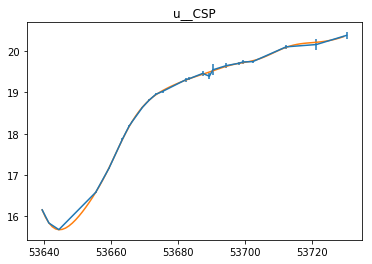

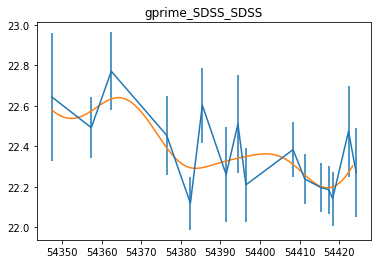

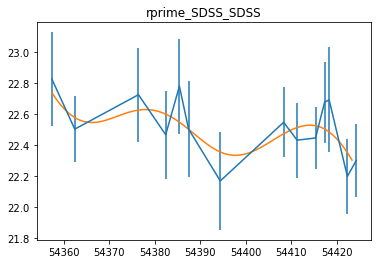

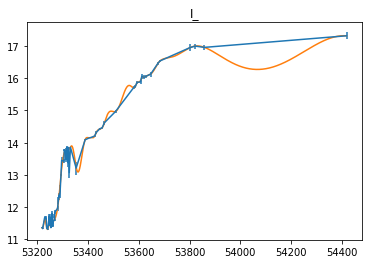

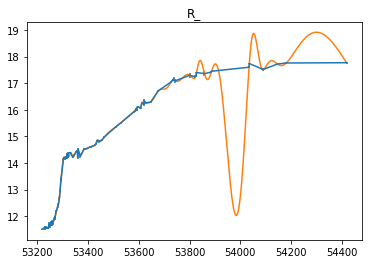

In [4]:
for filt in file_data:
    mjd = np.array(file_data[filt]['mjd'])
    mag = np.array(file_data[filt]['mag'])
    magerr = np.array(file_data[filt]['dmag'])
    modelmjd = file_data[filt]['modeldate']
    modelmag = file_data[filt]['modelmag']
    
    plt.errorbar(mjd,mag,yerr=magerr)
    plt.plot(modelmjd, modelmag)
    plt.title(filt)
    plt.show()

In [5]:
from george import kernels
#kernel = kernels.ConstantKernel(10) * kernels.ExpSquaredKernel(100.) * kernels.DotProductKernel()
#kernel = kernels.ExpSquaredKernel(10.) * kernels.DotProductKernel()
#kernel =  kernels.Matern32Kernel(100.)*kernels.ConstantKernel(100.) * kernels.ExpSquaredKernel(100.)
#kernel =  kernels.Matern32Kernel(50.) * kernels.ConstantKernel(50.) * kernels.ExpSquaredKernel(100) * kernels.DotProductKernel()
#kernel = kernels.Matern32Kernel(50.) * kernels.ExpSquaredKernel(500)
#kernel = kernels.ConstantKernel(50.) * kernels.Matern52Kernel(50.) * kernels.DotProductKernel() + kernels.WhiteKernel(0.5)
kernel = kernels.ConstantKernel(50.) * kernels.Matern52Kernel(50.) * kernels.DotProductKernel()
#kernel = kernels.ExpSquaredKernel(10.) + kernels.DotProductKernel()
#k1 = 6.0**2 * kernels.Matern52Kernel(100.)
#k2 = 0.66**2 * kernels.RationalQuadraticKernel(0.78, 1.2**2)
#k3 = 0.18**2 * kernels.ExpSquaredKernel(1.) + kernels.WhiteKernel(0.5)
#kernel = k1 + k3
#print(len(kernel))

In [6]:
import scipy.optimize as op

output_lcurves = {}

for filter_name in file_data:
    if filter_name == 'B__CSP':
        continue
    t = np.array(file_data[filter_name]['mjd'])
    y = np.array(file_data[filter_name]['mag'])
    err = np.array(file_data[filter_name]['dmag'])

    #gp = george.GP(kernel, mean=np.mean(y))
    gp = george.GP(kernel)

    # Define the objective function (negative log-likelihood in this case).
    def nll(p):
        # Update the kernel parameters and compute the likelihood.
        gp.kernel[:] = p
        ll = gp.lnlikelihood(y, quiet=True)

        # The scipy optimizer doesn't play well with infinities.
        return -ll if np.isfinite(ll) else 1e25

    # And the gradient of the objective function.
    def grad_nll(p):
        # Update the kernel parameters and compute the likelihood.
        gp.kernel[:] = p
        return -gp.grad_lnlikelihood(y, quiet=True)

    # You need to compute the GP once before starting the optimization.
    gp.compute(t, err)

    # Print the initial ln-likelihood.
    #print(gp.lnlikelihood(y))

    # Run the optimization routine.
    p0 = gp.kernel.vector
    #results = op.minimize(nll, p0, jac=grad_nll, bounds=[(np.log(25.),np.log(5000))])
    min_val = np.log(10**-4.)
    max_val = np.log(10**5.)
    min_val_exp = np.log(10**-3.)
    max_val_exp = np.log(10**4.)
    
    best_lnlikelihood = 1e25
    p = [p0*10**-i for i in range(-2,3)]

    for p0 in p:
        results = op.minimize(nll, p0, jac=grad_nll, bounds=[(min_val, max_val)]*len(kernel))
        if results.fun < best_lnlikelihood:
            final_results = results
    # Update the kernel and print the final log-likelihood.
    gp.kernel[:] = final_results.x
    #print(filter_name,final_results.success, final_results.message, final_results.fun, final_results.x)
    #print(gp.lnlikelihood(y))
    #print(gp.kernel.pars)
    
    x = np.linspace(min(t), max(t), 100)
    mu, cov = gp.predict(y,x)
    std = np.sqrt(np.diag(cov))
    #plt.plot(x,mu, color='r')
    #plt.errorbar(t,y,yerr=err)
    #plt.show()
    output_lcurves[filter_name] = {
        't': t,
        'y': y,
        'err': err,
        'out_t': x,
        'out_y': mu,
        'out_err': std,
        'pars': gp.kernel.pars
    }

In [7]:
#print(output_lcurves)

[  1.00000000e-04   1.00000000e+05]


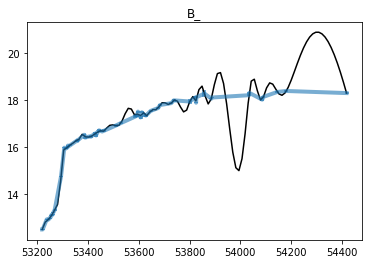

[  1.00000000e-04   1.00000000e+05]


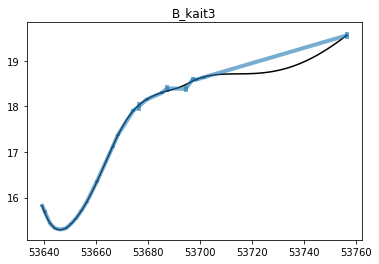

[  1.00000000e-04   8.87594538e+04]


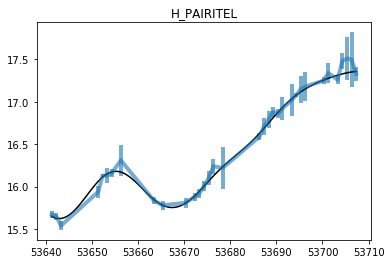

[  1.00000000e-04   8.22280186e+04]


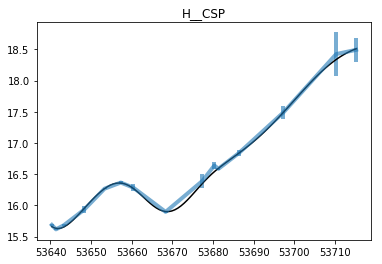

[  1.00000000e-04   6.63776228e+04]


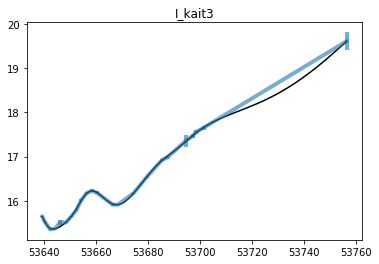

[  1.00000000e-04   5.87981769e+04]


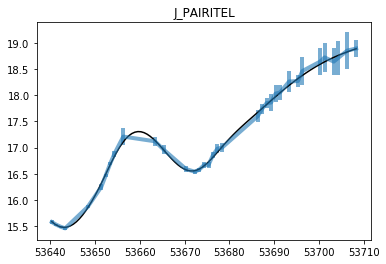

[  1.00000000e-04   3.70546937e+04]


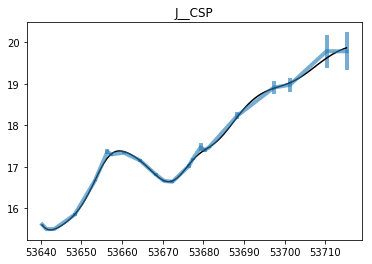

[  1.00000000e-04   9.23662373e+04]


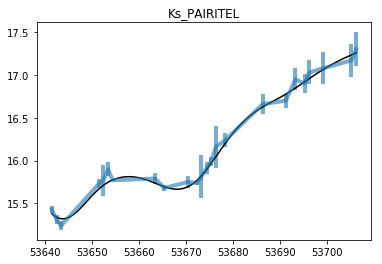

[  1.00000000e-04   6.95044350e+04]


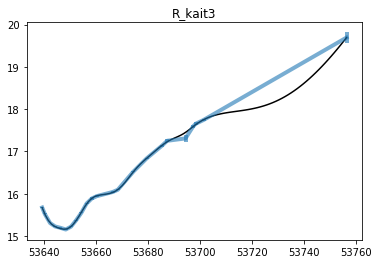

[  1.00000000e-04   1.00000000e+05]


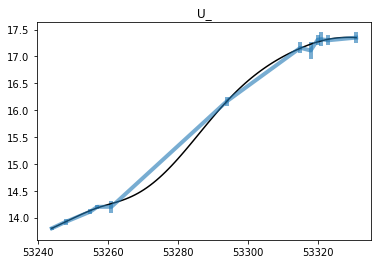

[  1.00000000e-04   1.00000000e+05]


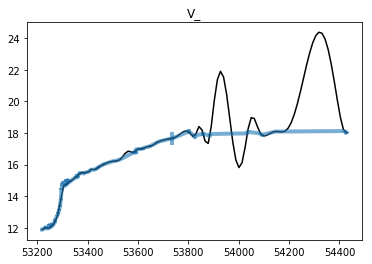

[  1.00000000e-04   1.00000000e+05]


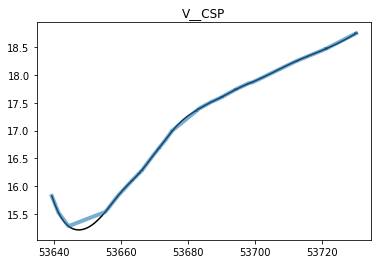

[  1.00000000e-04   1.00000000e+05]


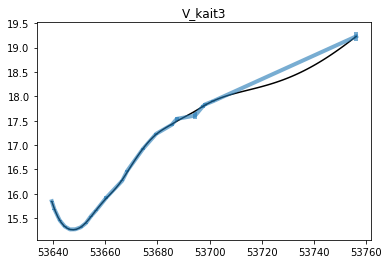

[  1.00000000e-04   7.19877490e+04]


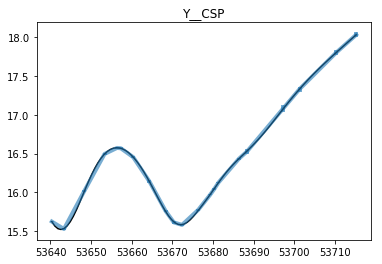

[  1.00000000e-04   1.00000000e+05]


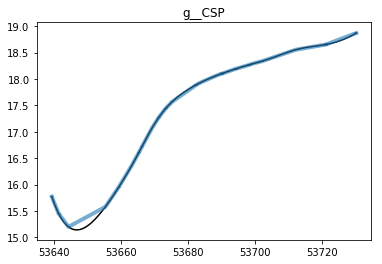

[  1.00000000e-04   6.26564447e+04]


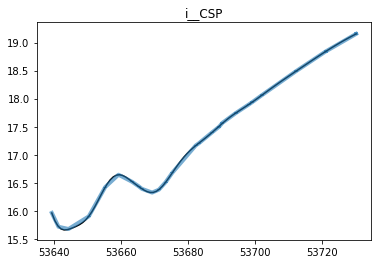

[  1.00000000e-04   1.00000000e+05]


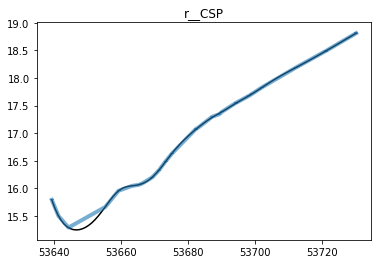

[  1.00000000e-04   1.00000000e+05]


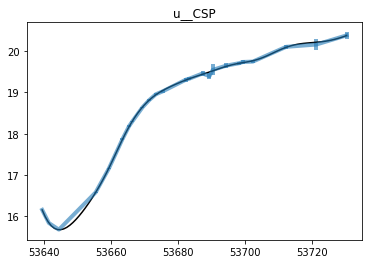

[  1.00000000e-04   1.00000000e+05]


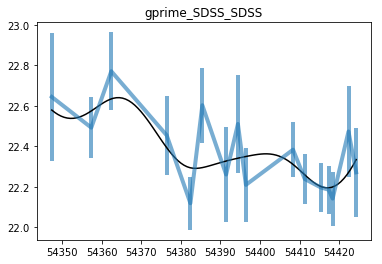

[  1.00000000e-04   1.00000000e+05]


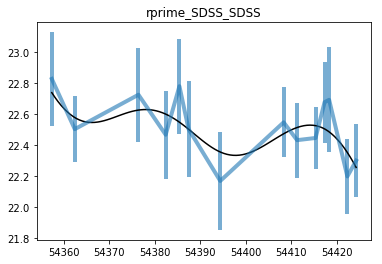

[  1.00000000e-04   1.00000000e+05]


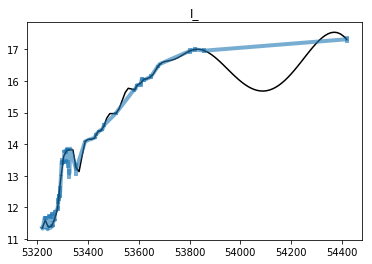

[  1.00000000e-04   1.00000000e+05]


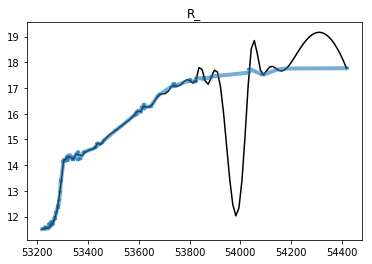

In [8]:
for filt in output_lcurves:
    #if not 'rpri' in filt:
    #    continue
    mjd = np.array(output_lcurves[filt]['t'])
    mag = np.array(output_lcurves[filt]['y'])
    magerr = np.array(output_lcurves[filt]['err'])
    modelmjd = output_lcurves[filt]['out_t']
    modelmag = output_lcurves[filt]['out_y']
    pars = output_lcurves[filt]['pars']
    print(pars)
    
    plt.errorbar(mjd,mag,yerr=magerr, alpha = 0.6, linewidth=4)
    plt.plot(modelmjd, modelmag, color='black')
    plt.title(filt)
    plt.show()